# *svoboda lab / tactile navigation / 1*

## Setup plotting

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')
sns.set_context('notebook')
from thunder import Colorize
image = Colorize.image

## Load the data

We load the data by first specifying a bucket and a path on Amazon S3, and then loading the different pieces separately.

In [2]:
bucket = "s3n://neuro.datasets/"
path = "svoboda.lab/tactile.navigation/1/"

### *Images*

The raw data are images of calcium flouresence, which we load into an `Images` object. We restrict the range of data between the 0 and 500th time point. This is only because we are working on a small machine and want to avoid loading the entire data set.

In [3]:
raw = tsc.loadImages(bucket + path + 'images', recursive=True, startIdx=0, stopIdx=500, npartitions=1)

We also subselect a single plane, blur, and downsample; this is again because we are on a single, small machine.

In [4]:
images = raw.planes(2,2).gaussianFilter(3).subsample(8)
images

Images
nrecords: 500
dtype: int16
dims: min=(0, 0), max=(63, 63), count=(64, 64)

Cache the data to keep it in RAM (and prevent reloading from S3)

In [5]:
images.cache()
images.count();

### *Parameters*

We can load and inspect covariates from the experiment, in this case, the mouse's running speed.

In [129]:
params = tsc.loadParams(bucket + path + 'params/covariates.json')

In [130]:
params

Params
names: ['runningSpeed']

### *Metadata*

Finally, we can load and display the metadata (stored as a JSON file)

In [131]:
metadata = tsc.loadJSON(bucket + path + 'info.json')

In [132]:
for k in metadata.keys():
    print('%s: %s' % (k, metadata[k]))

animal-state: Awake head-fixed
dimensions: [512, 512, 4, 9606]
contributors: [u'Nicholas Sofroniew', u'Karel Svoboda']
notes: Data reported in Freeman et al., 2014, Nature Methods
lab: Svoboda Lab
rate-hz: 7
experiment: Whisker-guided virtual reality
location: Janelia Research Campus
animal: Mouse
method: Two-photon imaging


## Inspect images

An `Images` object is a collection of records, each one an image. We can inspect individual images or compute simple summary statistics.

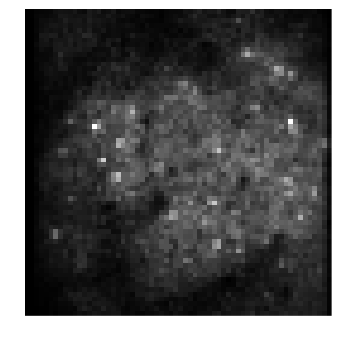

In [6]:
image(images.values().first(), clim=(0,500))

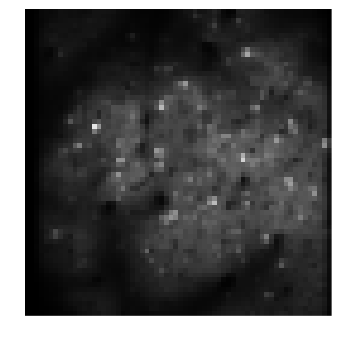

In [7]:
image(images.mean(), clim=(0,500))

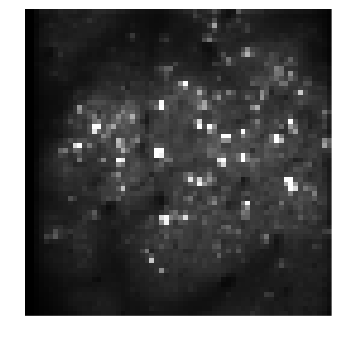

In [8]:
image(images.stdev(), clim=(0,100))

## Convert to time series

We can also explore the data as a collection of time series. Here we convert to time series and cache the result.

In [10]:
series = images.toTimeSeries()
series.cache()
series.count();

## Inspect as time series

Plot a random subset of pixel time series after simple filtering

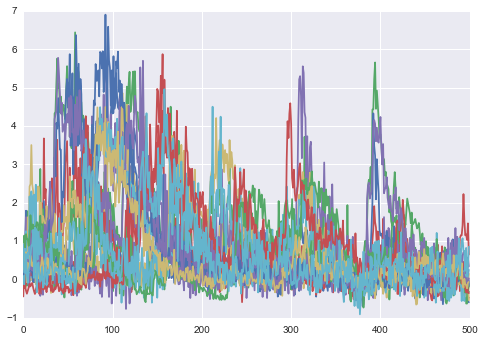

In [11]:
sample = series.squelch(100).normalize().subset(100, thresh=0.8)
plt.plot(sample.T);

## Pixel-wise correlation

Correlate every time series to the running speed and pack into a local image

In [31]:
im = series.correlate(params['runningSpeed'][0:500]).pack()

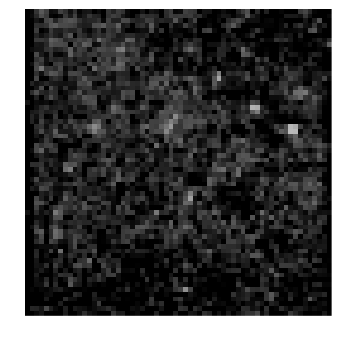

In [32]:
image(im, clim=(0, 0.4))